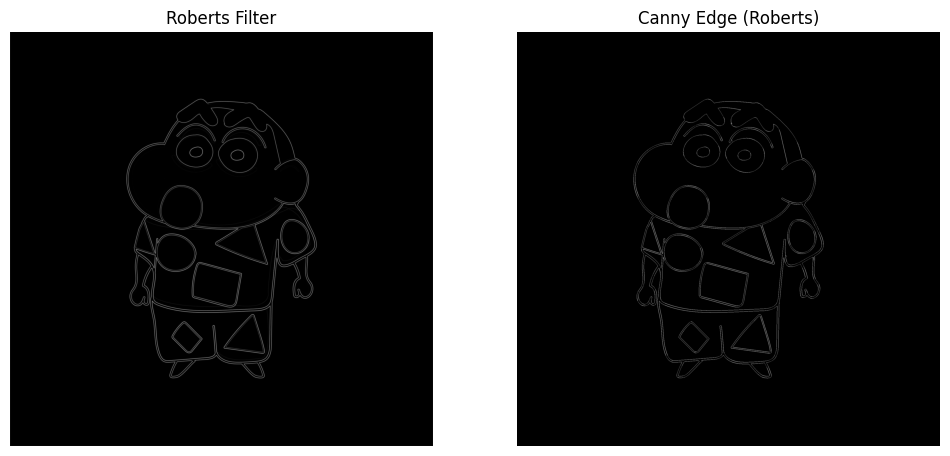

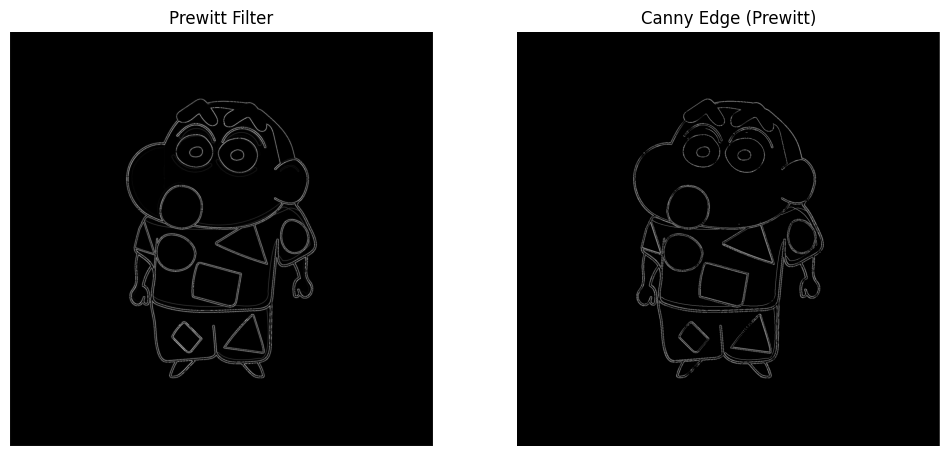

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_img(images, titles):
    plt.figure(figsize=(12, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

# Gaussian Blur
def gauss_blur(img, ks, sigma):
    size = ks // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    
    const = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0 * sigma**2))) * const
    g /= g.sum()
    
    return g

def apply_gaussian_blur(img, ks=5, sigma=0.5):
    gauss_kernel = gauss_blur(img, ks, sigma)
    return cv2.filter2D(img, -1, gauss_kernel)

# Roberts Filter
def roberts_filter(img):
    rob_x = np.array([[1, 0], [0, -1]])
    rob_y = np.array([[0, 1], [-1, 0]])
    
    grad_x = cv2.filter2D(img, cv2.CV_64F, rob_x)
    grad_y = cv2.filter2D(img, cv2.CV_64F, rob_y)
    
    robert_filt = np.uint8(np.sqrt(np.square(grad_x) + np.square(grad_y)))
    return np.abs(grad_x), np.abs(grad_y), robert_filt

# Prewitt Filter
def prewitt_filter(img):
    pr_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    pr_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    
    grad_x = cv2.filter2D(img, cv2.CV_64F, pr_x)
    grad_y = cv2.filter2D(img, cv2.CV_64F, pr_y)
    
    prewitt_filt = np.uint8(np.sqrt(np.square(grad_x) + np.square(grad_y)))
    return np.abs(grad_x), np.abs(grad_y), prewitt_filt

# Non-Max Suppression
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            q = 255
            r = 255
            
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = img[i, j+1]
                r = img[i, j-1]
            elif (22.5 <= angle[i, j] < 67.5):
                q = img[i+1, j-1]
                r = img[i-1, j+1]
            elif (67.5 <= angle[i, j] < 112.5):
                q = img[i+1, j]
                r = img[i-1, j]
            elif (112.5 <= angle[i, j] < 157.5):
                q = img[i-1, j-1]
                r = img[i+1, j+1]
            
            if (img[i, j] >= q) and (img[i, j] >= r):
                Z[i, j] = img[i, j]
            else:
                Z[i, j] = 0
    
    return Z

# Thresholding
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.25):
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = img.max() * lowThresholdRatio

    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)

    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i, weak_j = np.where((img < highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res, weak, strong

# Hysteresis
def hysteresis(img, weak=50, strong=255):
    M, N = img.shape  
    img_copy = img.copy()

    for i in range(1, M-1):
        for j in range(1, N-1):
            if img_copy[i, j] == weak:
                if np.any(img_copy[i-1:i+2, j-1:j+2] == strong):
                    img_copy[i, j] = strong
                else:
                    img_copy[i, j] = 0
    
    return img_copy

# Process Image
def process_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred_img = apply_gaussian_blur(img)
    
    roberts_x, roberts_y, roberts_res = roberts_filter(blurred_img)
    prewitt_x, prewitt_y, prewitt_res = prewitt_filter(blurred_img)
    
    Suppressed_roberts = non_max_suppression(roberts_res, np.arctan2(roberts_y, roberts_x))
    Suppressed_prewitt = non_max_suppression(prewitt_res, np.arctan2(prewitt_y, prewitt_x))
    
    thres_roberts, wk_r, strng_r = threshold(Suppressed_roberts)
    Fin_roberts = hysteresis(thres_roberts, wk_r, strng_r)
    
    thres_prewitt, wk_p, strng_p = threshold(Suppressed_prewitt)
    Fin_prewitt = hysteresis(thres_prewitt, wk_p, strng_p)
    
    show_img([roberts_res, Fin_roberts], ['Roberts Filter', 'Canny Edge (Roberts)'])
    show_img([prewitt_res, Fin_prewitt], ['Prewitt Filter', 'Canny Edge (Prewitt)'])

process_image('images/shinchan.jpg')
